In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from astroquery.esa.euclid.core import EuclidClass, Euclid
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.nddata.utils import Cutout2D
from multiprocessing.pool import ThreadPool
from astropy import wcs
from astropy.io import fits
import numpy as np
import pandas as pd
#import sep
import glob
import os

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from astropy.table import Table
from astropy.visualization import astropy_mpl_style, ImageNormalize, ZScaleInterval, PercentileInterval, AsinhStretch, SqrtStretch, SquaredStretch
plt.style.use(astropy_mpl_style)
pd.set_option('display.max_colwidth', 0) #to show full column content (no wrapping and no dots)

/tmp/ipykernel_363/3496465029.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [17]:
# change to your username|
Euclid.login(user='mwalms01')

INFO: Login to Euclid TAP server [astroquery.esa.euclid.core]


Password:  ········


INFO: OK [astroquery.utils.tap.core]
INFO: Login to Euclid data service [astroquery.esa.euclid.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Login to Euclid cutout service [astroquery.esa.euclid.core]
INFO: OK [astroquery.utils.tap.core]


In [33]:
rand_fraction = 0.05

query_str = f"""
            SELECT right_ascension, declination, object_id, segmentation_map_id, segmentation_area, flux_segmentation, spurious_prob, vis_det, det_quality_flag, flag_vis, flag_y, flux_g_ext_decam_aper, flux_i_ext_decam_aper, flux_r_ext_decam_aper
            FROM catalogue.mer_catalogue
            WHERE segmentation_area > 100
            AND gaia_id IS NULL
            AND vis_det=1
            AND spurious_prob < 0.2
            AND declination < 0
            AND RAND() < {rand_fraction}
            """

job = Euclid.launch_job_async(query_str, background=False, dump_to_file=True, output_file='latest_all_southern_sources.csv', output_format='csv')

In [34]:

df = pd.read_csv('latest_all_southern_sources.csv')
len(df), int(len(df) / rand_fraction)

(901915, 18038300)

In [35]:
df['tile_index'] = df['segmentation_map_id'].apply(lambda x: str(x)[:10])

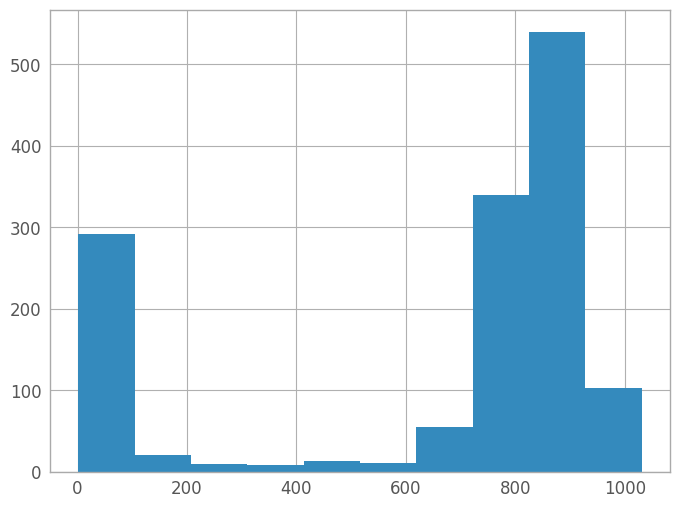

In [36]:
_ = plt.hist(df['tile_index'].value_counts().values)

In [47]:
len(df['tile_index'].unique())

1390

In [44]:
good_tiles = list((df['tile_index'].value_counts() > 600).index)
len(good_tiles)

1390

In [45]:
df = df[df['tile_index'].isin(good_tiles)]

In [46]:
len(df)

901915

In [48]:

def flux_to_mag(flux):
    return -2.5 * np.log10(flux) + 23.9

def mag_to_flux(mag):
    return 10 ** ((mag - 23.9)/-2.5)

def add_mag_photometry(df):
    df = df.copy()
    df['g_mag'] = flux_to_mag(df['flux_g_ext_decam_aper'])
    df['i_mag'] = flux_to_mag(df['flux_i_ext_decam_aper'])
    df['r_mag'] = flux_to_mag(df['flux_r_ext_decam_aper'])

    df['g_minus_i_mag'] = df['g_mag'] - df['i_mag']
    df['g_minus_r_mag'] = df['g_mag'] - df['r_mag']
    
    df['mag_segmentation'] = -2.5 * np.log10(df['flux_segmentation']) + 23.9
    return df

df = add_mag_photometry(df)
# gz = add_mag_photometry(gz)


/opt/miniconda/envs/euclid-tools/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda/envs/euclid-tools/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/miniconda/envs/euclid-tools/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [49]:
def apply_strong_lens_cut(df):
    good_r = (df['r_mag'] < 22.5) & (df['r_mag'] > 18)
    good_g = df['g_mag'] > 20
    good_i = (df['i_mag'] < 23.5) & (df['i_mag'] > 18.2)
    good_gi = (df['g_minus_i_mag'] < 5) & (df['g_minus_i_mag'] > 1.8)
    good_gr = (df['g_minus_r_mag'] < 3) & (df['g_minus_r_mag'] > 0.6)

    print(good_r.mean(), good_g.mean(), good_i.mean(), good_gi.mean(), good_gr.mean())
    
    good_all = good_r & good_g & good_i & good_gi & good_gr
    print(good_all.mean())
    
    return df[good_all]

In [50]:
# def color_mag_lim_to_color_flux_lim(mag_lim):
#     return 10 ** (-mag_lim / 2.5)
    

# for lim in (5, 1.8, 3, 0.6):
#     print(lim, color_mag_lim_to_color_flux_lim(lim))

In [51]:
# # need to convert these limits to flux
# for lim in (22.5, 18, 18.2, 20, 23.5, 18.2):
#     print(lim, mag_to_flux(lim))

In [52]:
maybe_lens = apply_strong_lens_cut(df)

0.24070006597074003 0.9807664802115499 0.796741378067778 0.2214975912364247 0.6066469678406502
0.0789741827112311


In [53]:
len(maybe_lens)/len(df)  # after also applying the QA cuts

0.0789741827112311

In [59]:
galaxies_per_tile = len(df)/len(df['tile_index'].unique()) / rand_fraction
galaxies_per_tile

12977.194244604316

In [ ]:
# tiles are 30x30 arcminutes (core area) i.e. 0.5 x 0.5 degrees
# so area of 0.25 deg squared
# q1 is 50 sq deg so 50 / 0.25 = about 200 tiles

In [60]:
galaxies_per_tile * 200 

2595438.848920863